# PHYS 434 Lab 4: Working with "real" data

In [75]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import stats
import h5py

from scipy.stats import poisson
from scipy.stats import norm

#this sets the size of the plot to something useful
# plt.rcParams["figure.figsize"] = (20,15)

In [2]:
# import the file for Problem 1
hf = h5py.File('gammaray_lab4.h5', 'r')

# import the file for Problem 2
hp2 = h5py.File('images.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
# import the data into an array variable using the get method
data = np.array(hf.get('data'))

Data should have a time (in gps seconds), Solar phase (deg), Earth longitude (deg), and gamma-ray counts, and more than 25 million data records.

In [5]:
# print out the first row
print(data[:,0])
print(data)

[9.40680016e+08 3.15000000e+02 4.50000000e+01 1.00000000e+01]
[[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
  9.43272016e+08 9.43272016e+08]
 [3.15000000e+02 3.15007112e+02 3.15014225e+02 ... 3.45319109e+02
  3.45326221e+02 3.45333333e+02]
 [4.50000000e+01 4.50066667e+01 4.50133333e+01 ... 4.49866667e+01
  4.49933333e+01 4.50000000e+01]
 [1.00000000e+01 8.00000000e+00 7.00000000e+00 ... 8.00000000e+00
  1.10000000e+01 1.20000000e+01]]


In [35]:
time = data[0,:]
solarPhase = data[1,:]
earthLongitude = data[2,:]
gammarayCounts = data[3,:]
print(time)
print(time.size)

[9.40680016e+08 9.40680016e+08 9.40680016e+08 ... 9.43272016e+08
 9.43272016e+08 9.43272016e+08]
25920001


In [7]:
# close the file
hf.close()

## Problem 1
In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

1) Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

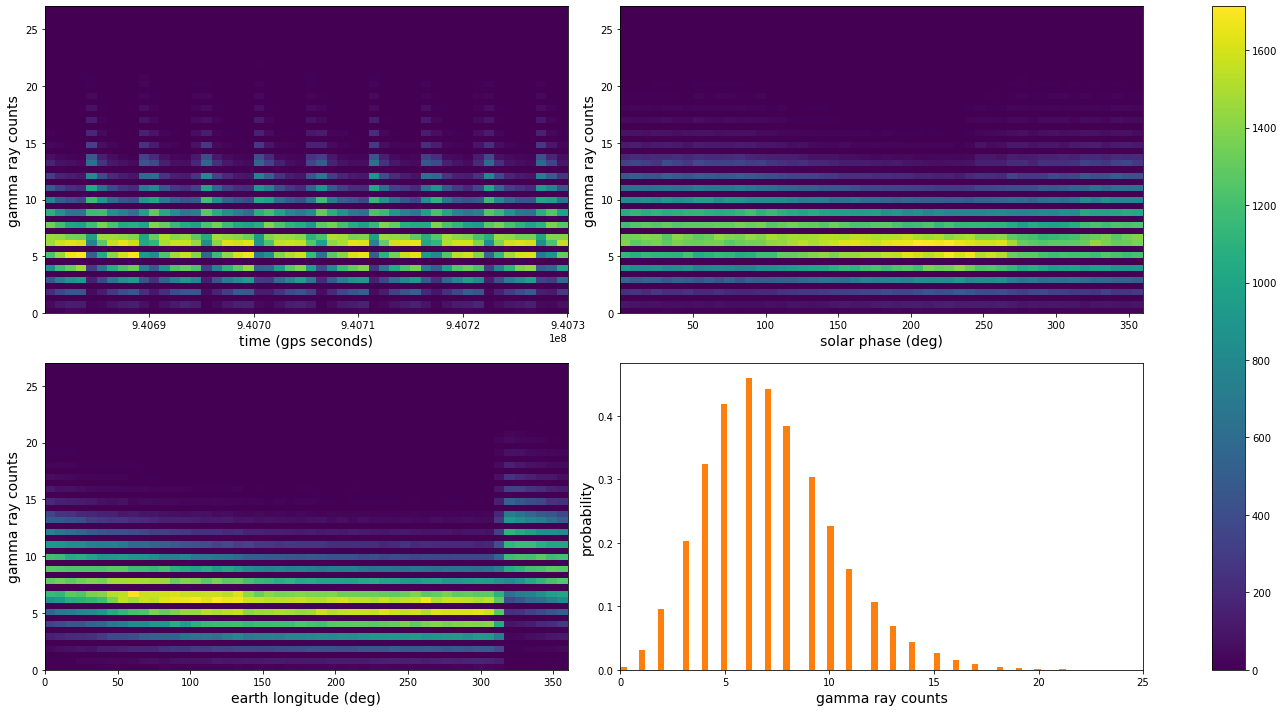

In [8]:
# create a figure with 4 subplots
fig, ax = plt.subplots(2, 2, figsize= (20, 10))

start = 0
end = 500000

# plot solar phase vs time
h = ax[0,0].hist2d(time[start:end], gammarayCounts[start:end], bins = 50);
h = ax[0,1].hist2d(solarPhase[start:end], gammarayCounts[start:end], bins = 50);
h = ax[1,0].hist2d(earthLongitude[start:end], gammarayCounts[start:end], bins = 50);

# x y label
ax[0,0].set_xlabel("time (gps seconds)", fontsize = 14)
ax[0,0].set_ylabel("gamma ray counts",fontsize = 14)
ax[0,1].set_xlabel("solar phase (deg)", fontsize = 14)
ax[0,1].set_ylabel("gamma ray counts", fontsize = 14)
ax[1,0].set_xlabel("earth longitude (deg)", fontsize = 14)
ax[1,0].set_ylabel("gamma ray counts", fontsize = 14)

plt.tight_layout() # minimize the overlap between 2 subplots
plt.colorbar(h[3], ax=ax);

ax[1,1].hist(gammarayCounts, bins = 100, density = True);
ax[1,1].hist(gammarayCounts, bins = 100, density = True);
ax[1,1].set_xlim([0,25]);
ax[1,1].set_xlabel("gamma ray counts", fontsize = 14);
ax[1,1].set_ylabel("probability", fontsize = 14);


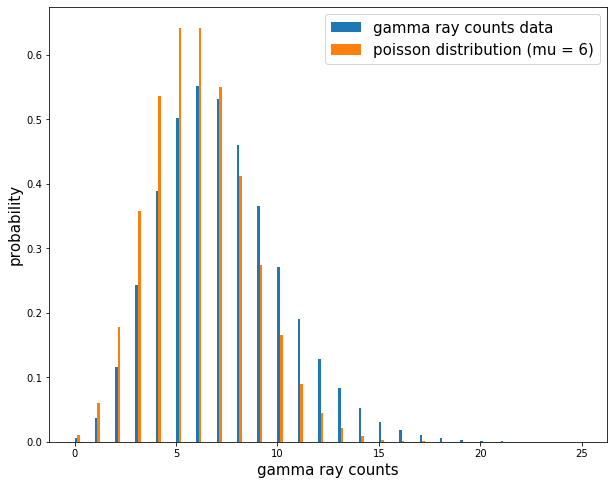

In [34]:
# plot gamma ray background on the same axes with poisson
fig, ax = plt.subplots(1,1,figsize= (10, 8))


# create a random poisson distribution
poi = poisson.rvs(mu = 6, size = gammarayCounts.size);
plt.hist([gammarayCounts,poi], bins = 100, range = [0,25], density = True, rwidth = 10);
plt.xlabel("gamma ray counts", fontsize = 15);
plt.ylabel("probability", fontsize = 15);
plt.legend(["gamma ray counts data", "poisson distribution (mu = 6)"], fontsize = 15);


base on the physical meaning of how the measurements are taken, it should be poisson, but the plot above doesn't show possion, so maybe contaminated
describe the data is discrete

2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

background varies with longitude and time

3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

poisson with mean changing with time
every 90 min(5400 s) it's a poisson, but the mean of those poisson changes in some kind of pattern exp probably

In [141]:
# break down the time array into bins each with 90 mins(5400s) for a complete period
time_2 = np.arange(time[0], time[time.size-1], 5400)
numberOfPeriods = time_2.size
print("Our data set has " + str(numberOfPeriods) + " periods")

## plot the gamma ray count distribution for the first period
## divide the first two periods into multiple bins, then fit each bin with poission and keep track of the mean value
# create an empty array to store the mean
mean = np.empty(0)

# initialize variables used in for loop
t_start = time[0]
t_end = time[0] + 10800

end = 0
# try to find the index correspond to the first period
for i in range(time.size):
    if time[i] > t_end:
        end = i-1 # index for the right end of the first period
        break
# print(end)
# print(time[end] - time[0])

Our data set has 480 periods


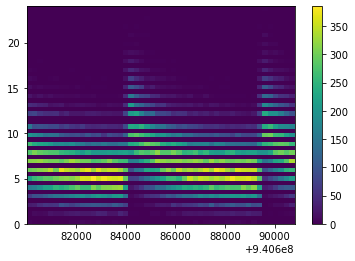

In [142]:
# plot solar phase vs time
plt.hist2d(time[0:end], gammarayCounts[0:end], bins = 50);
plt.colorbar();

Now we are going to use this part of the data, divide it into some number of bins, identify the distribution of gamma-ray counts within each bin, find it's mean value depending on the type of distribution (we suspect it would be a poisson distribution based on the physical meaning of the measurements), collect the mean value for each bin, plot the mean values, and figure out its time dependency. <br>
The color bar in the 2D histogram represents the number of events; the brighter the color on one pixel, the more events there are on that pixel. From the gamma-ray counts vs. time plots above, we can see that the mean gamma-ray counts decay within each period. Therefore, we suspect the time dependence of the mean of poisson distribution follows exponential decay. To check this, I will perform the procedures described above and plot out how the mean changes with time. 

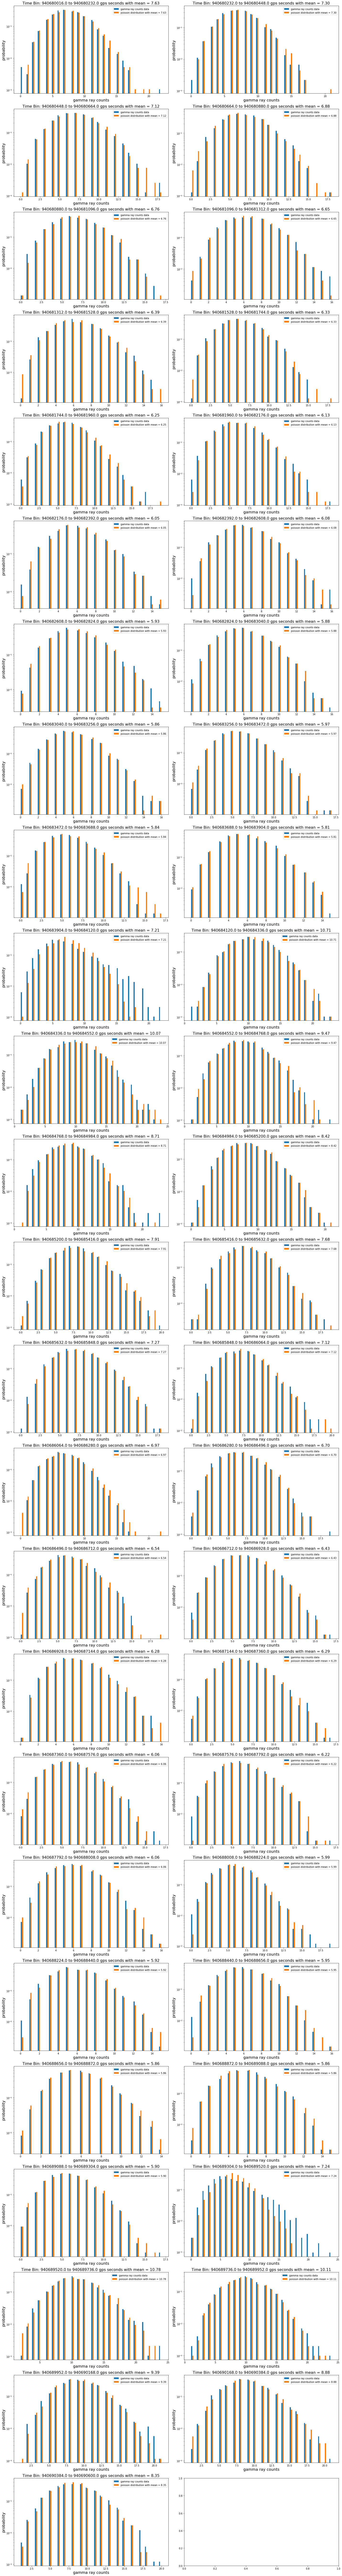

In [143]:
# define the sub data we are using for this part
sub_time = time[0:end]
sub_gammarayCounts = gammarayCounts[0:end]

# define how many bins I want to divide the region above
binCounts = 50
binSize = int(sub_time.size / binCounts)

## divide the data into bins and plot the distribution in each bin out
# create subplots
fig, ax = plt.subplots(25, 2, figsize=(20, 150))
row = 0
col = 0

# create empty mean array to store mean for each bin
mean = np.empty(0)

# fill data into each plot
for i in range(binCounts-1): # the distribution in each bin fills a subplot
    # get time and gammarayCounts(x) for each bin
    timeLeft = sub_time[i*binSize]
    timeRight = sub_time[(i+1)*binSize]
    x = sub_gammarayCounts[i*binSize : (i+1)*binSize]
    
    # create a poisson distribution
    meanInBin = np.mean(sub_gammarayCounts[i*binSize : (i+1)*binSize])
    poissonPerBin = poisson.rvs(mu = meanInBin, size = x.size)
    
    # append meanInBin to mean array
    mean = np.append(mean, meanInBin)
    
    # fill subplot
    ax[row,col].hist([x,poissonPerBin], bins = 50, density = True)
    ax[row,col].set_title("Time Bin: " + str(timeLeft) + " to " + str(timeRight) + " gps seconds with mean = %.2f" %meanInBin, fontsize = 16)
    ax[row,col].set_xlabel("gamma ray counts", fontsize = 16)
    ax[row,col].set_ylabel("probability", fontsize = 16)
    ax[row,col].legend(["gamma ray counts data", "poisson distribution with mean = %.2f" %meanInBin])
    ax[row,col].set_yscale("log")
    
    plt.tight_layout()
    
    # move to the next sub plot
    if (col < 1) : # same row, filling the other columns in the same row
        row = row
        col = col + 1
    else : # this row is full, go to next row, start filling from column 0
        row = row + 1
        col = 0


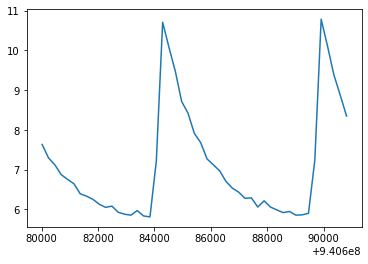

In [144]:
# plot the mean array and find out its time dependence
x_mean = np.linspace(sub_time[0], sub_time[sub_time.size-1], mean.size)

plt.plot(x_mean, mean);

4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

Optional: while this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?

## Problem 2
In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

1) Download the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [11]:
# check the content in the file
hp2.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [12]:
# import the data into an array variable using the get method
image1 = np.array(hp2.get('image1'))
imagestack = np.array(hp2.get('imagestack'))

print(image1.shape)
print(imagestack.shape)

print(imagestack)

(200, 200)
(200, 200, 10)
[[[-0.50492093  0.24975188 -0.50405229 ... -0.06210173  1.19841096
   -0.5545422 ]
  [ 0.31347367  0.51688201 -0.31138079 ...  0.33398174  0.55016787
   -0.34058838]
  [ 0.77349547  0.67896143 -0.6113714  ...  0.27080669 -0.68046639
    0.18246055]
  ...
  [-0.04589657  0.97223818 -0.71404873 ...  0.65576281 -0.54599168
    0.21560286]
  [-0.11759723  0.62046056  0.09021457 ... -0.34188113  0.54884142
   -0.08468977]
  [ 0.73567588  0.03022051 -0.24726976 ... -0.23116598 -0.26072648
   -0.52367269]]

 [[-0.25288444  0.40016073 -0.30428969 ... -0.44263445  1.03162128
    0.09690978]
  [-0.29488745  0.55482416  0.42734028 ... -0.4764485   0.69531261
    1.30498548]
  [-1.22944512 -0.42300837  0.2854878  ...  0.07939523 -0.49463113
    0.22676201]
  ...
  [-0.83559631 -0.56840005  0.45623228 ...  0.14847145 -0.3343485
   -1.3334321 ]
  [-1.1240839  -0.22375506  0.686933   ... -1.03628551  0.02506734
    1.02583188]
  [ 0.90479232  1.26561108  0.02618609 ...  0.22

In [13]:
# save data of each image to an array
im_1 = imagestack[:,:,0]
im_2 = imagestack[:,:,1]
im_3 = imagestack[:,:,2]
im_4 = imagestack[:,:,3]
im_5 = imagestack[:,:,4]
im_6 = imagestack[:,:,5]
im_7 = imagestack[:,:,6]
im_8 = imagestack[:,:,7]
im_9 = imagestack[:,:,8]
im_10 = imagestack[:,:,9]
print(im_1.shape)
print(im_1)
# print(im_2)


(200, 200)
[[-0.50492093  0.31347367  0.77349547 ... -0.04589657 -0.11759723
   0.73567588]
 [-0.25288444 -0.29488745 -1.22944512 ... -0.83559631 -1.1240839
   0.90479232]
 [ 0.82669501 -0.3006203  -0.03294592 ... -0.35059418 -0.21134798
   0.2446972 ]
 ...
 [-0.04421337 -0.41529871 -0.53750713 ... -0.25819324 -0.11397904
   0.63726362]
 [ 0.1371078  -0.16054595  0.06292987 ... -0.18569491 -0.15209693
  -0.51340031]
 [-0.63545846 -0.67648944 -0.81114124 ... -0.69407377  0.27650752
  -0.65854951]]


2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

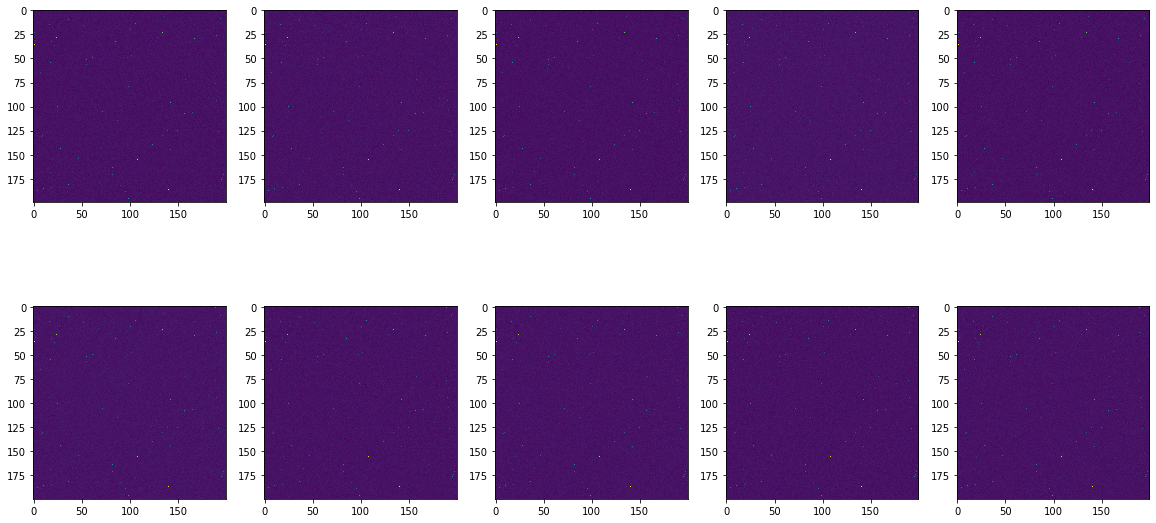

In [108]:
# create a figure with 10 subplots
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax[0,0].imshow(im_1);
ax[0,1].imshow(im_2);
ax[0,2].imshow(im_3);
ax[0,3].imshow(im_4);
ax[0,4].imshow(im_5);
ax[1,0].imshow(im_6);
ax[1,1].imshow(im_7);
ax[1,2].imshow(im_8);
ax[1,3].imshow(im_9);
ax[1,4].imshow(im_10);

not time dependent, consistent spatially

In [67]:
## calculate the background pdf()

# first take the difference between all 10 images
imDiff_12 = im_1 - im_2
imDiff_13 = im_1 - im_3
imDiff_14 = im_1 - im_4
imDiff_15 = im_1 - im_5
imDiff_16 = im_1 - im_6
imDiff_17 = im_1 - im_7
imDiff_18 = im_1 - im_8
imDiff_19 = im_1 - im_9
imDiff_110 = im_1 - im_10

# sum all the difference
sumDiff = imDiff_12 + imDiff_13 + imDiff_14 + imDiff_15 + imDiff_16 + imDiff_17 + imDiff_18 + imDiff_19 + imDiff_110

# average the sum diff
avgDiff = sumDiff / 9

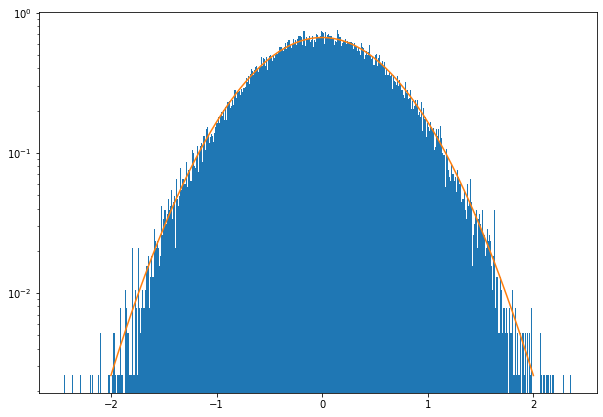

In [88]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))

# plot avgDiff 
ax.hist(np.ravel(avgDiff), bins = 500, density = True);

# create x values for norm.pdf
x = np.linspace(-2,2,avgDiff.size)
normpdf = norm.pdf(x, loc = 0, scale = 0.6)

# plot norm pdf
ax.plot(x, normpdf)
ax.set_yscale("log")

3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.

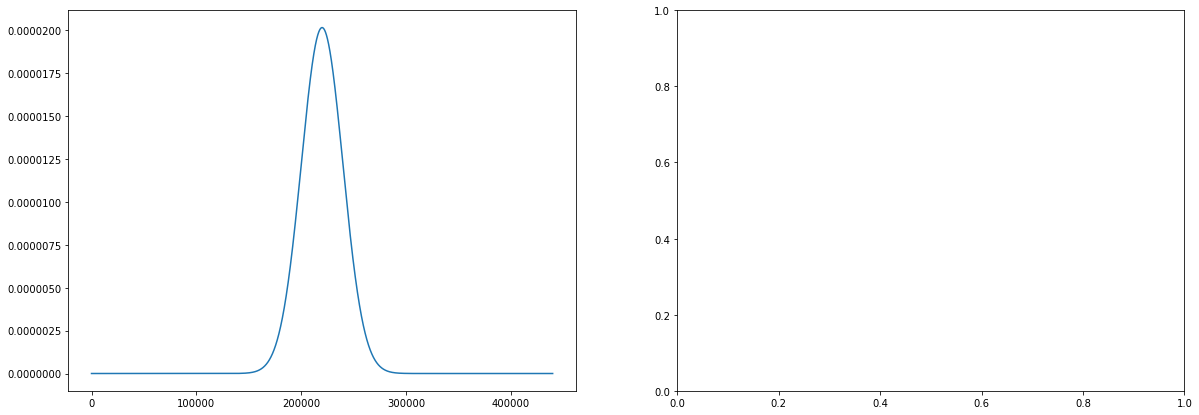

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
## find super nova
## assume each image is taken within 1s

# create x values for norm.pdf
x = np.linspace(-2,2,avgDiff.size)
normpdf_1 = norm.pdf(x, loc = 0, scale = 0.6)
normpdf_2 = norm.pdf(x, loc = 0, scale = 0.6)

# convolve gaussian for 10 seconds
timeDuration = 10 # second
for i in range(0, timeDuration):
    normpdf_1 = np.convolve(normpdf_1, normpdf_2)
    normpdf_10s = normpdf_1

# normalize pdf
normpdf_10s = normpdf_10s / normpdf_10s.sum()

ax[0].plot(normpdf_10s);
# plt.title("PDF of the background for 5 days");
# plt.xlabel("Number of Gamma-rays Emitted");
# plt.ylabel("Probability");

# plot average of convolution
x_avg = x / 10
# ax[1].plot(x_avg,normpdf_10s)

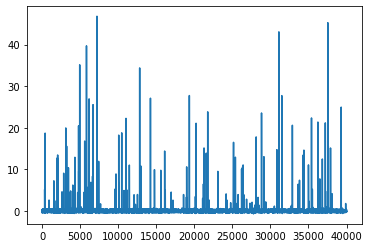

In [93]:
# sum all 10 images
sumIm = im_1 + im_2 + im_3 + im_4 + im_5 + im_6 + im_7 + im_8 + im_9 + im_10
avgIm = sumIm / 10

plt.plot(np.ravel(avgIm));


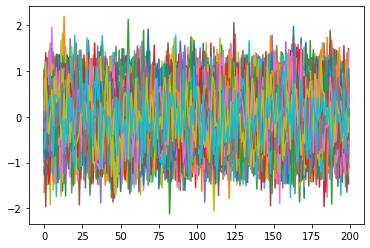

In [92]:
plt.plot(avgIm - im_1);

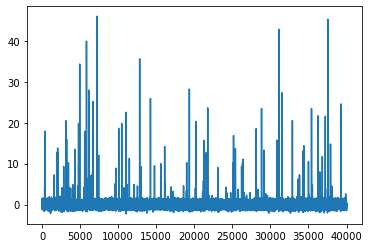

In [80]:
plt.plot(np.ravel(im_1))


In [86]:
print(im_1.max())

46.01175269422071


4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.

In [20]:
im_sum = im_1 + im_2 + im_3 + im_4 + im_5 + im_6 + im_7 + im_8 + im_9 + im_10

image = np.empty(0)

for i in range(200):
    for j in range(200):
        image = np.append(image, im_sum[i,j])

(40000,)


(0, 100)

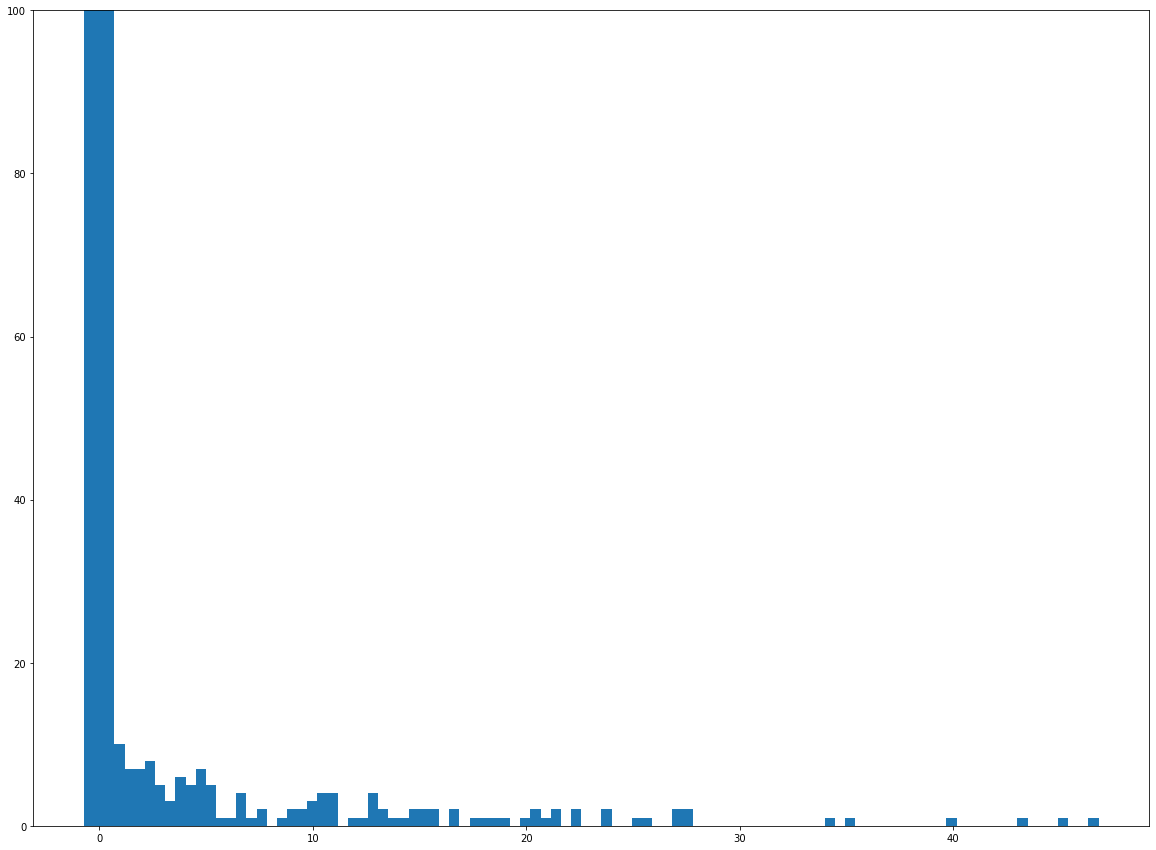

In [21]:
print(image.shape)
plt.rcParams["figure.figsize"] = (20,15)
x = np.linspace(0,50,40000)
plt.hist(image/10, bins = 100);
# plt.xlim(-10,10);
plt.ylim(0, 100)